In [87]:
import pandas as pd
from pyspark.sql import SparkSession
import os
import matplotlib.pyplot as plt
from tabulate import tabulate

### Config

In [88]:
# Determine whether to materialize the parameters of models
SAVE_MODEL = False

### Preprocess

In [89]:
if not os.path.exists('./car_prices_without_null.csv'):
    # 加载数据
    df = pd.read_csv('./car_prices.csv')

    # 检查所有列
    print(df.info())

    # 删除包含空值的行
    df = df.dropna()

    # 写入新文件
    df.to_csv('./car_prices_without_null.csv', index=False)

In [90]:
spark = SparkSession.builder.appName('5003_project').getOrCreate()
sc = spark.sparkContext

In [91]:
spark.version

'3.3.2'

In [92]:
data = spark.read.csv('./car_prices_without_null.csv', header=True, inferSchema=True)
data.show(10)

+----+---------+-------------------+--------------------+-----------+------------+-----------------+-----+---------+--------+-----+--------+--------------------+-------+------------+--------------------+
|year|     make|              model|                trim|       body|transmission|              vin|state|condition|odometer|color|interior|              seller|    mmr|sellingprice|            saledate|
+----+---------+-------------------+--------------------+-----------+------------+-----------------+-----+---------+--------+-----+--------+--------------------+-------+------------+--------------------+
|2015|      Kia|            Sorento|                  LX|        SUV|   automatic|5xyktca69fg566472|   ca|      5.0| 16639.0|white|   black|kia motors americ...|20500.0|     21500.0|Tue Dec 16 2014 1...|
|2015|      Kia|            Sorento|                  LX|        SUV|   automatic|5xyktca69fg561319|   ca|      5.0|  9393.0|white|   beige|kia motors americ...|20800.0|     21500.0|Tu

In [93]:
data.printSchema()

root
 |-- year: integer (nullable = true)
 |-- make: string (nullable = true)
 |-- model: string (nullable = true)
 |-- trim: string (nullable = true)
 |-- body: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- vin: string (nullable = true)
 |-- state: string (nullable = true)
 |-- condition: double (nullable = true)
 |-- odometer: double (nullable = true)
 |-- color: string (nullable = true)
 |-- interior: string (nullable = true)
 |-- seller: string (nullable = true)
 |-- mmr: double (nullable = true)
 |-- sellingprice: double (nullable = true)
 |-- saledate: string (nullable = true)



In [94]:
data.rdd.getNumPartitions()

19

### Data Cleaning

In [95]:
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import StringIndexer, OneHotEncoder

In [96]:
# 创建StringIndexer对象
stringIndexer = StringIndexer(inputCol="make", outputCol="make_index")

# 使用StringIndexer对象进行转换
indexedData = stringIndexer.fit(data).transform(data)

# 将"make_index"列转换为整数类型
indexedData = indexedData.withColumn("make_index", col("make_index").cast(IntegerType()))

# 替换"make"列为"make_index"列
indexedData = indexedData.withColumn("make", col("make_index")).drop("make_index")

encoder = OneHotEncoder(inputCol="make", outputCol="oh")
encoded = encoder.fit(indexedData).transform(indexedData)
encoded = encoded.withColumn("make", col("oh")).drop("oh")

# 查看转换后的数据
# data = indexedData
data = encoded
data.show()

+----+---------------+-------------------+--------------------+-----------+------------+-----------------+-----+---------+--------+------+--------+--------------------+-------+------------+--------------------+
|year|           make|              model|                trim|       body|transmission|              vin|state|condition|odometer| color|interior|              seller|    mmr|sellingprice|            saledate|
+----+---------------+-------------------+--------------------+-----------+------------+-----------------+-----+---------+--------+------+--------+--------------------+-------+------------+--------------------+
|2015| (52,[8],[1.0])|            Sorento|                  LX|        SUV|   automatic|5xyktca69fg566472|   ca|      5.0| 16639.0| white|   black|kia motors americ...|20500.0|     21500.0|Tue Dec 16 2014 1...|
|2015| (52,[8],[1.0])|            Sorento|                  LX|        SUV|   automatic|5xyktca69fg561319|   ca|      5.0|  9393.0| white|   beige|kia motor

In [97]:
# 处理state列
stringIndexer = StringIndexer(inputCol="state", outputCol="state_index")
indexedData = stringIndexer.fit(data).transform(data)
indexedData = indexedData.withColumn("state_index", col("state_index").cast(IntegerType()))
indexedData = indexedData.withColumn("state", col("state_index")).drop("state_index")

encoder = OneHotEncoder(inputCol="state", outputCol="oh")
encoded = encoder.fit(indexedData).transform(indexedData)
encoded = encoded.withColumn("state", col("oh")).drop("oh")

data = encoded
data.show()

+----+---------------+-------------------+--------------------+-----------+------------+-----------------+--------------+---------+--------+------+--------+--------------------+-------+------------+--------------------+
|year|           make|              model|                trim|       body|transmission|              vin|         state|condition|odometer| color|interior|              seller|    mmr|sellingprice|            saledate|
+----+---------------+-------------------+--------------------+-----------+------------+-----------------+--------------+---------+--------+------+--------+--------------------+-------+------------+--------------------+
|2015| (52,[8],[1.0])|            Sorento|                  LX|        SUV|   automatic|5xyktca69fg566472|(33,[1],[1.0])|      5.0| 16639.0| white|   black|kia motors americ...|20500.0|     21500.0|Tue Dec 16 2014 1...|
|2015| (52,[8],[1.0])|            Sorento|                  LX|        SUV|   automatic|5xyktca69fg561319|(33,[1],[1.0])

In [98]:
# 处理model列
stringIndexer = StringIndexer(inputCol="model", outputCol="model_index")
indexedData = stringIndexer.fit(data).transform(data)
indexedData = indexedData.withColumn("model_index", col("model_index").cast(IntegerType()))
indexedData = indexedData.withColumn("model", col("model_index")).drop("model_index")

encoder = OneHotEncoder(inputCol="model", outputCol="oh")
encoded = encoder.fit(indexedData).transform(indexedData)
encoded = encoded.withColumn("model", col("oh")).drop("oh")

data = encoded
data.show()

+----+---------------+-----------------+--------------------+-----------+------------+-----------------+--------------+---------+--------+------+--------+--------------------+-------+------------+--------------------+
|year|           make|            model|                trim|       body|transmission|              vin|         state|condition|odometer| color|interior|              seller|    mmr|sellingprice|            saledate|
+----+---------------+-----------------+--------------------+-----------+------------+-----------------+--------------+---------+--------+------+--------+--------------------+-------+------------+--------------------+
|2015| (52,[8],[1.0])| (767,[40],[1.0])|                  LX|        SUV|   automatic|5xyktca69fg566472|(33,[1],[1.0])|      5.0| 16639.0| white|   black|kia motors americ...|20500.0|     21500.0|Tue Dec 16 2014 1...|
|2015| (52,[8],[1.0])| (767,[40],[1.0])|                  LX|        SUV|   automatic|5xyktca69fg561319|(33,[1],[1.0])|      5.0

In [99]:
# 处理transmission
stringIndexer = StringIndexer(inputCol="transmission", outputCol="transmission_index")
indexedData = stringIndexer.fit(data).transform(data)
indexedData = indexedData.withColumn("transmission_index", col("transmission_index").cast(IntegerType()))
indexedData = indexedData.withColumn("transmission", col("transmission_index")).drop("transmission_index")

encoder = OneHotEncoder(inputCol="transmission", outputCol="oh")
encoded = encoder.fit(indexedData).transform(indexedData)
encoded = encoded.withColumn("transmission", col("oh")).drop("oh")

data = encoded
data.show()

+----+---------------+-----------------+--------------------+-----------+-------------+-----------------+--------------+---------+--------+------+--------+--------------------+-------+------------+--------------------+
|year|           make|            model|                trim|       body| transmission|              vin|         state|condition|odometer| color|interior|              seller|    mmr|sellingprice|            saledate|
+----+---------------+-----------------+--------------------+-----------+-------------+-----------------+--------------+---------+--------+------+--------+--------------------+-------+------------+--------------------+
|2015| (52,[8],[1.0])| (767,[40],[1.0])|                  LX|        SUV|(1,[0],[1.0])|5xyktca69fg566472|(33,[1],[1.0])|      5.0| 16639.0| white|   black|kia motors americ...|20500.0|     21500.0|Tue Dec 16 2014 1...|
|2015| (52,[8],[1.0])| (767,[40],[1.0])|                  LX|        SUV|(1,[0],[1.0])|5xyktca69fg561319|(33,[1],[1.0])|    

In [100]:
# 处理trim
stringIndexer = StringIndexer(inputCol="trim", outputCol="trim_index")
indexedData = stringIndexer.fit(data).transform(data)
indexedData = indexedData.withColumn("trim_index", col("trim_index").cast(IntegerType()))
indexedData = indexedData.withColumn("trim", col("trim_index")).drop("trim_index")

# encoder = OneHotEncoder(inputCol="trim", outputCol="oh")
# encoded = encoder.fit(indexedData).transform(indexedData)
# encoded = encoded.withColumn("trim", col("oh")).drop("oh")

# data = encoded
data = indexedData
data.show()

+----+---------------+-----------------+----+-----------+-------------+-----------------+--------------+---------+--------+------+--------+--------------------+-------+------------+--------------------+
|year|           make|            model|trim|       body| transmission|              vin|         state|condition|odometer| color|interior|              seller|    mmr|sellingprice|            saledate|
+----+---------------+-----------------+----+-----------+-------------+-----------------+--------------+---------+--------+------+--------+--------------------+-------+------------+--------------------+
|2015| (52,[8],[1.0])| (767,[40],[1.0])|   2|        SUV|(1,[0],[1.0])|5xyktca69fg566472|(33,[1],[1.0])|      5.0| 16639.0| white|   black|kia motors americ...|20500.0|     21500.0|Tue Dec 16 2014 1...|
|2015| (52,[8],[1.0])| (767,[40],[1.0])|   2|        SUV|(1,[0],[1.0])|5xyktca69fg561319|(33,[1],[1.0])|      5.0|  9393.0| white|   beige|kia motors americ...|20800.0|     21500.0|Tue Dec

In [101]:
# 处理body
stringIndexer = StringIndexer(inputCol="body", outputCol="body_index")
indexedData = stringIndexer.fit(data).transform(data)
indexedData = indexedData.withColumn("body_index", col("body_index").cast(IntegerType()))
indexedData = indexedData.withColumn("body", col("body_index")).drop("body_index")

encoder = OneHotEncoder(inputCol="body", outputCol="oh")
encoded = encoder.fit(indexedData).transform(indexedData)
encoded = encoded.withColumn("body", col("oh")).drop("oh")

data = encoded
data.show()

+----+---------------+-----------------+----+--------------+-------------+-----------------+--------------+---------+--------+------+--------+--------------------+-------+------------+--------------------+
|year|           make|            model|trim|          body| transmission|              vin|         state|condition|odometer| color|interior|              seller|    mmr|sellingprice|            saledate|
+----+---------------+-----------------+----+--------------+-------------+-----------------+--------------+---------+--------+------+--------+--------------------+-------+------------+--------------------+
|2015| (52,[8],[1.0])| (767,[40],[1.0])|   2|(84,[1],[1.0])|(1,[0],[1.0])|5xyktca69fg566472|(33,[1],[1.0])|      5.0| 16639.0| white|   black|kia motors americ...|20500.0|     21500.0|Tue Dec 16 2014 1...|
|2015| (52,[8],[1.0])| (767,[40],[1.0])|   2|(84,[1],[1.0])|(1,[0],[1.0])|5xyktca69fg561319|(33,[1],[1.0])|      5.0|  9393.0| white|   beige|kia motors americ...|20800.0|     

In [102]:
# 处理color
stringIndexer = StringIndexer(inputCol="color", outputCol="color_index")
indexedData = stringIndexer.fit(data).transform(data)
indexedData = indexedData.withColumn("color_index", col("color_index").cast(IntegerType()))
indexedData = indexedData.withColumn("color", col("color_index")).drop("color_index")

encoder = OneHotEncoder(inputCol="color", outputCol="oh")
encoded = encoder.fit(indexedData).transform(indexedData)
encoded = encoded.withColumn("color", col("oh")).drop("oh")

data = encoded
data.show()

+----+---------------+-----------------+----+--------------+-------------+-----------------+--------------+---------+--------+--------------+--------+--------------------+-------+------------+--------------------+
|year|           make|            model|trim|          body| transmission|              vin|         state|condition|odometer|         color|interior|              seller|    mmr|sellingprice|            saledate|
+----+---------------+-----------------+----+--------------+-------------+-----------------+--------------+---------+--------+--------------+--------+--------------------+-------+------------+--------------------+
|2015| (52,[8],[1.0])| (767,[40],[1.0])|   2|(84,[1],[1.0])|(1,[0],[1.0])|5xyktca69fg566472|(33,[1],[1.0])|      5.0| 16639.0|(19,[1],[1.0])|   black|kia motors americ...|20500.0|     21500.0|Tue Dec 16 2014 1...|
|2015| (52,[8],[1.0])| (767,[40],[1.0])|   2|(84,[1],[1.0])|(1,[0],[1.0])|5xyktca69fg561319|(33,[1],[1.0])|      5.0|  9393.0|(19,[1],[1.0])|   

In [103]:
# 处理interior
stringIndexer = StringIndexer(inputCol="interior", outputCol="interior_index")
indexedData = stringIndexer.fit(data).transform(data)
indexedData = indexedData.withColumn("interior_index", col("interior_index").cast(IntegerType()))
indexedData = indexedData.withColumn("interior", col("interior_index")).drop("interior_index")

encoder = OneHotEncoder(inputCol="interior", outputCol="oh")
encoded = encoder.fit(indexedData).transform(indexedData)
encoded = encoded.withColumn("interior", col("oh")).drop("oh")

data = encoded
data.show()

+----+---------------+-----------------+----+--------------+-------------+-----------------+--------------+---------+--------+--------------+--------------+--------------------+-------+------------+--------------------+
|year|           make|            model|trim|          body| transmission|              vin|         state|condition|odometer|         color|      interior|              seller|    mmr|sellingprice|            saledate|
+----+---------------+-----------------+----+--------------+-------------+-----------------+--------------+---------+--------+--------------+--------------+--------------------+-------+------------+--------------------+
|2015| (52,[8],[1.0])| (767,[40],[1.0])|   2|(84,[1],[1.0])|(1,[0],[1.0])|5xyktca69fg566472|(33,[1],[1.0])|      5.0| 16639.0|(19,[1],[1.0])|(16,[0],[1.0])|kia motors americ...|20500.0|     21500.0|Tue Dec 16 2014 1...|
|2015| (52,[8],[1.0])| (767,[40],[1.0])|   2|(84,[1],[1.0])|(1,[0],[1.0])|5xyktca69fg561319|(33,[1],[1.0])|      5.0|  9

In [104]:
# 处理seller
stringIndexer = StringIndexer(inputCol="seller", outputCol="seller_index")
indexedData = stringIndexer.fit(data).transform(data)
indexedData = indexedData.withColumn("seller_index", col("seller_index").cast(IntegerType()))
indexedData = indexedData.withColumn("seller", col("seller_index")).drop("seller_index")

# encoder = OneHotEncoder(inputCol="seller", outputCol="oh")
# encoded = encoder.fit(indexedData).transform(indexedData)
# encoded = encoded.withColumn("seller", col("oh")).drop("oh")

# data = encoded
data = indexedData
data.show()

+----+---------------+-----------------+----+--------------+-------------+-----------------+--------------+---------+--------+--------------+--------------+------+-------+------------+--------------------+
|year|           make|            model|trim|          body| transmission|              vin|         state|condition|odometer|         color|      interior|seller|    mmr|sellingprice|            saledate|
+----+---------------+-----------------+----+--------------+-------------+-----------------+--------------+---------+--------+--------------+--------------+------+-------+------------+--------------------+
|2015| (52,[8],[1.0])| (767,[40],[1.0])|   2|(84,[1],[1.0])|(1,[0],[1.0])|5xyktca69fg566472|(33,[1],[1.0])|      5.0| 16639.0|(19,[1],[1.0])|(16,[0],[1.0])|    23|20500.0|     21500.0|Tue Dec 16 2014 1...|
|2015| (52,[8],[1.0])| (767,[40],[1.0])|   2|(84,[1],[1.0])|(1,[0],[1.0])|5xyktca69fg561319|(33,[1],[1.0])|      5.0|  9393.0|(19,[1],[1.0])|(16,[2],[1.0])|    23|20800.0|     

In [105]:
# 显示"saledate"列的前10条数据
saledate_data = data.select("saledate").head(10)

# 打印前10条数据
for row in saledate_data:
    print(row.saledate)

Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
Thu Jan 15 2015 04:30:00 GMT-0800 (PST)
Thu Jan 29 2015 04:30:00 GMT-0800 (PST)
Thu Dec 18 2014 12:30:00 GMT-0800 (PST)
Tue Dec 30 2014 12:00:00 GMT-0800 (PST)
Wed Dec 17 2014 12:30:00 GMT-0800 (PST)
Tue Dec 16 2014 13:00:00 GMT-0800 (PST)
Thu Dec 18 2014 12:00:00 GMT-0800 (PST)
Tue Jan 20 2015 04:00:00 GMT-0800 (PST)


In [106]:
from pyspark.sql.functions import substring, unix_timestamp

# 将"timestamp_string"列转换为Unix时间戳
data = data.withColumn("timestamp_string", substring("saledate", 5, 20))
data = data.withColumn("timestamp", unix_timestamp("timestamp_string", "MMM dd yyyy HH:mm:ss"))

data = data.drop('saledate')
data = data.drop('timestamp_string')
data = data.drop('vin')

# 查看转换后的数据
data.show()

+----+---------------+-----------------+----+--------------+-------------+--------------+---------+--------+--------------+--------------+------+-------+------------+----------+
|year|           make|            model|trim|          body| transmission|         state|condition|odometer|         color|      interior|seller|    mmr|sellingprice| timestamp|
+----+---------------+-----------------+----+--------------+-------------+--------------+---------+--------+--------------+--------------+------+-------+------------+----------+
|2015| (52,[8],[1.0])| (767,[40],[1.0])|   2|(84,[1],[1.0])|(1,[0],[1.0])|(33,[1],[1.0])|      5.0| 16639.0|(19,[1],[1.0])|(16,[0],[1.0])|    23|20500.0|     21500.0|1418704200|
|2015| (52,[8],[1.0])| (767,[40],[1.0])|   2|(84,[1],[1.0])|(1,[0],[1.0])|(33,[1],[1.0])|      5.0|  9393.0|(19,[1],[1.0])|(16,[2],[1.0])|    23|20800.0|     21500.0|1418704200|
|2014| (52,[7],[1.0])|  (767,[8],[1.0])| 636|(84,[0],[1.0])|(1,[0],[1.0])|(33,[1],[1.0])|     45.0|  1331.0|(1

In [107]:
# 将"timestamp"列丢弃末两位
data = data.withColumn("timestamp_str", data["timestamp"].cast("string"))
data = data.withColumn("timestamp_str_truncated", substring("timestamp_str", 0, 8))
data = data.withColumn("timestamp_int", data["timestamp_str_truncated"].cast("integer"))

data = data.drop('timestamp_str')
data = data.drop('timestamp_str_truncated')
data = data.drop('timestamp')
data = data.withColumnRenamed("timestamp_int", "timestamp")


data.show()

+----+---------------+-----------------+----+--------------+-------------+--------------+---------+--------+--------------+--------------+------+-------+------------+---------+
|year|           make|            model|trim|          body| transmission|         state|condition|odometer|         color|      interior|seller|    mmr|sellingprice|timestamp|
+----+---------------+-----------------+----+--------------+-------------+--------------+---------+--------+--------------+--------------+------+-------+------------+---------+
|2015| (52,[8],[1.0])| (767,[40],[1.0])|   2|(84,[1],[1.0])|(1,[0],[1.0])|(33,[1],[1.0])|      5.0| 16639.0|(19,[1],[1.0])|(16,[0],[1.0])|    23|20500.0|     21500.0| 14187042|
|2015| (52,[8],[1.0])| (767,[40],[1.0])|   2|(84,[1],[1.0])|(1,[0],[1.0])|(33,[1],[1.0])|      5.0|  9393.0|(19,[1],[1.0])|(16,[2],[1.0])|    23|20800.0|     21500.0| 14187042|
|2014| (52,[7],[1.0])|  (767,[8],[1.0])| 636|(84,[0],[1.0])|(1,[0],[1.0])|(33,[1],[1.0])|     45.0|  1331.0|(19,[3]

In [108]:
data.printSchema()
print(data.dtypes)

root
 |-- year: integer (nullable = true)
 |-- make: vector (nullable = true)
 |-- model: vector (nullable = true)
 |-- trim: integer (nullable = true)
 |-- body: vector (nullable = true)
 |-- transmission: vector (nullable = true)
 |-- state: vector (nullable = true)
 |-- condition: double (nullable = true)
 |-- odometer: double (nullable = true)
 |-- color: vector (nullable = true)
 |-- interior: vector (nullable = true)
 |-- seller: integer (nullable = true)
 |-- mmr: double (nullable = true)
 |-- sellingprice: double (nullable = true)
 |-- timestamp: integer (nullable = true)

[('year', 'int'), ('make', 'vector'), ('model', 'vector'), ('trim', 'int'), ('body', 'vector'), ('transmission', 'vector'), ('state', 'vector'), ('condition', 'double'), ('odometer', 'double'), ('color', 'vector'), ('interior', 'vector'), ('seller', 'int'), ('mmr', 'double'), ('sellingprice', 'double'), ('timestamp', 'int')]


In [109]:
# 1. 检查数据中是否存在 null 值
null_cols = [col for col in data.columns if data.select(col).where(data[col].isNull()).count() > 0]
if null_cols:
    print(f"Null values found in columns: {', '.join(null_cols)}")

In [110]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols = ['year', 'make', 'model', 'trim','body', 'transmission', 'state', 'condition', 'odometer', 'color', 'interior', 'seller', 'mmr', 'timestamp'], outputCol = 'features')
output = assembler.transform(data)
output.show(1)

24/04/29 01:54:35 WARN DAGScheduler: Broadcasting large task binary with size 1023.0 KiB
+----+--------------+----------------+----+--------------+-------------+--------------+---------+--------+--------------+--------------+------+-------+------------+---------+--------------------+
|year|          make|           model|trim|          body| transmission|         state|condition|odometer|         color|      interior|seller|    mmr|sellingprice|timestamp|            features|
+----+--------------+----------------+----+--------------+-------------+--------------+---------+--------+--------------+--------------+------+-------+------------+---------+--------------------+
|2015|(52,[8],[1.0])|(767,[40],[1.0])|   2|(84,[1],[1.0])|(1,[0],[1.0])|(33,[1],[1.0])|      5.0| 16639.0|(19,[1],[1.0])|(16,[0],[1.0])|    23|20500.0|     21500.0| 14187042|(979,[0,9,93,820,...|
+----+--------------+----------------+----+--------------+-------------+--------------+---------+--------+--------------+------

In [111]:
output.printSchema()

root
 |-- year: integer (nullable = true)
 |-- make: vector (nullable = true)
 |-- model: vector (nullable = true)
 |-- trim: integer (nullable = true)
 |-- body: vector (nullable = true)
 |-- transmission: vector (nullable = true)
 |-- state: vector (nullable = true)
 |-- condition: double (nullable = true)
 |-- odometer: double (nullable = true)
 |-- color: vector (nullable = true)
 |-- interior: vector (nullable = true)
 |-- seller: integer (nullable = true)
 |-- mmr: double (nullable = true)
 |-- sellingprice: double (nullable = true)
 |-- timestamp: integer (nullable = true)
 |-- features: vector (nullable = true)



In [112]:
final_data = output.select(['features', 'sellingprice'])
final_data = final_data.dropna()
final_data.show(3, truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------+------------+
|features                                                                                                                                  |sellingprice|
+------------------------------------------------------------------------------------------------------------------------------------------+------------+
|(979,[0,9,93,820,822,905,907,939,940,942,960,976,977,978],[2015.0,1.0,1.0,2.0,1.0,1.0,1.0,5.0,16639.0,1.0,1.0,23.0,20500.0,1.4187042E7])  |21500.0     |
|(979,[0,9,93,820,822,905,907,939,940,942,962,976,977,978],[2015.0,1.0,1.0,2.0,1.0,1.0,1.0,5.0,9393.0,1.0,1.0,23.0,20800.0,1.4187042E7])   |21500.0     |
|(979,[0,8,61,820,821,905,907,939,940,944,960,976,977,978],[2014.0,1.0,1.0,636.0,1.0,1.0,1.0,45.0,1331.0,1.0,1.0,14.0,31900.0,1.4212674E7])|30000.0     |
+---------------------------------------------------------------------------

In [113]:
final_data.printSchema()

root
 |-- features: vector (nullable = true)
 |-- sellingprice: double (nullable = true)



In [114]:
final_data.describe().show()

+-------+-----------------+
|summary|     sellingprice|
+-------+-----------------+
|  count|           472325|
|   mean|13690.51205843434|
| stddev|  9613.0337376916|
|    min|              1.0|
|    max|         230000.0|
+-------+-----------------+



### Train-Test Split

In [115]:
train, test = final_data.randomSplit([0.8,0.2])

In [116]:
# 查看数量
train_count = train.count()
test_count = test.count()
print("Number of samples in train set:", train_count)
print("Number of samples in test set:", test_count)

24/04/29 01:54:37 WARN DAGScheduler: Broadcasting large task binary with size 1113.3 KiB


24/04/29 01:54:38 WARN DAGScheduler: Broadcasting large task binary with size 1113.3 KiB


Number of samples in train set: 378094
Number of samples in test set: 94231


### Evaluation Function

In [117]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="sellingprice", predictionCol="prediction")

def evaluate(pred):
    rmse = evaluator.evaluate(pred, {evaluator.metricName: "rmse"})
    r2 = evaluator.evaluate(pred, {evaluator.metricName: "r2"})
    mae = evaluator.evaluate(pred, {evaluator.metricName: "mae"})

    return rmse, r2, mae


### Model Save Function

In [118]:
def save_model(model, name):
    if SAVE_MODEL:
        if not os.path.exists('models'):
            os.makedirs('models')
        model.write().overwrite().save(f'models/{name}')

### Timer

In [119]:
import time
times = []

def timer(f):

    def func(*arg, **kwarg):
        s_time = time.time()
        res = f(*arg,**kwarg)
        e_time = time.time()
        t = e_time - s_time
        print(f'It took {t} second(s)')
        times.append(t)
        return res
    
    return func

### Linear Regression

In [120]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol='features', labelCol='sellingprice')

In [121]:
@timer
def lr_training():
    return lr.fit(train)

lr_model = lr_training()
# lr_model = lr.fit(train)

24/04/29 01:54:39 WARN Instrumentation: [8652523c] regParam is zero, which might cause numerical instability and overfitting.
24/04/29 01:54:39 WARN DAGScheduler: Broadcasting large task binary with size 1120.2 KiB


24/04/29 01:54:40 WARN DAGScheduler: Broadcasting large task binary with size 1121.3 KiB


24/04/29 01:54:41 WARN Instrumentation: [8652523c] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
24/04/29 01:54:41 WARN DAGScheduler: Broadcasting large task binary with size 1133.8 KiB


24/04/29 01:54:42 WARN DAGScheduler: Broadcasting large task binary with size 1134.9 KiB
It took 2.90539288520813 second(s)


In [122]:
lr_predictions = lr_model.transform(test)
lr_predictions.show(10)

24/04/29 01:54:42 WARN DAGScheduler: Broadcasting large task binary with size 1126.8 KiB
+--------------------+------------+------------------+
|            features|sellingprice|        prediction|
+--------------------+------------+------------------+
|(979,[0,1,54,820,...|     13800.0|14463.162076776294|
|(979,[0,1,54,820,...|     12700.0| 11787.55087350389|
|(979,[0,1,54,820,...|      9400.0| 8644.919857686953|
|(979,[0,1,54,820,...|     17500.0| 16641.41445432772|
|(979,[0,1,54,820,...|     14500.0|14943.664483904853|
|(979,[0,1,54,820,...|     14600.0| 14639.42266204195|
|(979,[0,1,54,820,...|     12600.0| 14278.51495513333|
|(979,[0,1,54,820,...|     20100.0|21316.067219375967|
|(979,[0,1,54,820,...|     15500.0|15671.746656587304|
|(979,[0,1,54,820,...|     21200.0|20590.291227541253|
+--------------------+------------+------------------+
only showing top 10 rows



In [123]:
lr_rmse, lr_r2, lr_mae = evaluate(lr_predictions)
lr_rmse, lr_r2, lr_mae

24/04/29 01:54:43 WARN DAGScheduler: Broadcasting large task binary with size 1134.5 KiB


24/04/29 01:54:44 WARN DAGScheduler: Broadcasting large task binary with size 1135.7 KiB
24/04/29 01:54:44 WARN DAGScheduler: Broadcasting large task binary with size 1134.5 KiB


24/04/29 01:54:45 WARN DAGScheduler: Broadcasting large task binary with size 1135.7 KiB
24/04/29 01:54:45 WARN DAGScheduler: Broadcasting large task binary with size 1134.5 KiB


24/04/29 01:54:46 WARN DAGScheduler: Broadcasting large task binary with size 1135.7 KiB


(1621.3495403482596, 0.9711211434945514, 1027.334611182129)

In [124]:
save_model(lr_model, 'linear_regression')

### Decision Tree

In [125]:
from pyspark.ml.regression import DecisionTreeRegressor

dt = DecisionTreeRegressor(featuresCol='features', labelCol='sellingprice')

In [126]:
@timer
def dt_training():
    return dt.fit(train)

dt_model = dt_training()
# dt_model = dt.fit(train)

24/04/29 01:54:46 WARN DAGScheduler: Broadcasting large task binary with size 1117.6 KiB
24/04/29 01:54:46 WARN DAGScheduler: Broadcasting large task binary with size 1117.6 KiB


24/04/29 01:54:47 WARN DAGScheduler: Broadcasting large task binary with size 1122.4 KiB


24/04/29 01:54:49 WARN DAGScheduler: Broadcasting large task binary with size 1149.3 KiB


24/04/29 01:54:49 WARN MemoryStore: Not enough space to cache rdd_1178_9 in memory! (computed 12.9 MiB so far)
24/04/29 01:54:49 WARN MemoryStore: Not enough space to cache rdd_1178_15 in memory! (computed 12.9 MiB so far)
24/04/29 01:54:49 WARN MemoryStore: Not enough space to cache rdd_1178_8 in memory! (computed 12.9 MiB so far)
24/04/29 01:54:49 WARN MemoryStore: Not enough space to cache rdd_1178_6 in memory! (computed 12.9 MiB so far)
24/04/29 01:54:49 WARN BlockManager: Persisting block rdd_1178_15 to disk instead.
24/04/29 01:54:49 WARN MemoryStore: Not enough space to cache rdd_1178_3 in memory! (computed 12.9 MiB so far)
24/04/29 01:54:49 WARN MemoryStore: Not enough space to cache rdd_1178_17 in memory! (computed 5.5 MiB so far)
24/04/29 01:54:49 WARN MemoryStore: Not enough space to cache rdd_1178_12 in memory! (computed 12.9 MiB so far)
24/04/29 01:54:49 WARN MemoryStore: Not enough space to cache rdd_1178_7 in memory! (computed 8.4 MiB so far)
24/04/29 01:54:49 WARN Memor

24/04/29 01:54:50 WARN MemoryStore: Not enough space to cache rdd_1178_11 in memory! (computed 8.4 MiB so far)
24/04/29 01:54:50 WARN MemoryStore: Not enough space to cache rdd_1178_16 in memory! (computed 8.4 MiB so far)
24/04/29 01:54:50 WARN MemoryStore: Not enough space to cache rdd_1178_9 in memory! (computed 12.9 MiB so far)
24/04/29 01:54:50 WARN MemoryStore: Not enough space to cache rdd_1178_4 in memory! (computed 8.4 MiB so far)
24/04/29 01:54:50 WARN MemoryStore: Not enough space to cache rdd_1178_8 in memory! (computed 12.9 MiB so far)
24/04/29 01:54:50 WARN MemoryStore: Not enough space to cache rdd_1178_2 in memory! (computed 19.4 MiB so far)
24/04/29 01:54:50 WARN MemoryStore: Not enough space to cache rdd_1178_10 in memory! (computed 12.9 MiB so far)
24/04/29 01:54:50 WARN MemoryStore: Not enough space to cache rdd_1178_0 in memory! (computed 12.9 MiB so far)
24/04/29 01:54:50 WARN MemoryStore: Not enough space to cache rdd_1178_17 in memory! (computed 5.5 MiB so far)
2

24/04/29 01:54:51 WARN MemoryStore: Not enough space to cache rdd_1178_11 in memory! (computed 5.5 MiB so far)
24/04/29 01:54:51 WARN MemoryStore: Not enough space to cache rdd_1178_14 in memory! (computed 3.6 MiB so far)
24/04/29 01:54:51 WARN MemoryStore: Not enough space to cache rdd_1178_12 in memory! (computed 5.5 MiB so far)
24/04/29 01:54:51 WARN MemoryStore: Not enough space to cache rdd_1178_7 in memory! (computed 8.4 MiB so far)
24/04/29 01:54:51 WARN MemoryStore: Not enough space to cache rdd_1178_4 in memory! (computed 3.6 MiB so far)
24/04/29 01:54:51 WARN MemoryStore: Not enough space to cache rdd_1178_8 in memory! (computed 2.4 MiB so far)
24/04/29 01:54:51 WARN MemoryStore: Not enough space to cache rdd_1178_5 in memory! (computed 5.5 MiB so far)
24/04/29 01:54:51 WARN MemoryStore: Not enough space to cache rdd_1178_6 in memory! (computed 5.5 MiB so far)
24/04/29 01:54:51 WARN MemoryStore: Not enough space to cache rdd_1178_15 in memory! (computed 5.5 MiB so far)
24/04/

24/04/29 01:54:52 WARN MemoryStore: Not enough space to cache rdd_1178_11 in memory! (computed 5.5 MiB so far)
24/04/29 01:54:52 WARN MemoryStore: Not enough space to cache rdd_1178_10 in memory! (computed 5.5 MiB so far)
24/04/29 01:54:52 WARN MemoryStore: Not enough space to cache rdd_1178_4 in memory! (computed 5.5 MiB so far)
24/04/29 01:54:52 WARN MemoryStore: Not enough space to cache rdd_1178_14 in memory! (computed 8.4 MiB so far)
24/04/29 01:54:52 WARN MemoryStore: Not enough space to cache rdd_1178_2 in memory! (computed 5.5 MiB so far)
24/04/29 01:54:52 WARN MemoryStore: Not enough space to cache rdd_1178_16 in memory! (computed 5.5 MiB so far)
24/04/29 01:54:52 WARN MemoryStore: Not enough space to cache rdd_1178_15 in memory! (computed 5.5 MiB so far)
24/04/29 01:54:52 WARN MemoryStore: Not enough space to cache rdd_1178_9 in memory! (computed 5.5 MiB so far)
24/04/29 01:54:52 WARN MemoryStore: Not enough space to cache rdd_1178_7 in memory! (computed 5.5 MiB so far)
24/04

In [127]:
dt_predictions = dt_model.transform(test)
dt_predictions.show(10)

24/04/29 01:54:53 WARN DAGScheduler: Broadcasting large task binary with size 1126.5 KiB
+--------------------+------------+------------------+
|            features|sellingprice|        prediction|
+--------------------+------------+------------------+
|(979,[0,1,54,820,...|     13800.0| 14831.54048104362|
|(979,[0,1,54,820,...|     12700.0|10772.440787217993|
|(979,[0,1,54,820,...|      9400.0|  8804.88310831611|
|(979,[0,1,54,820,...|     17500.0|16038.247040013828|
|(979,[0,1,54,820,...|     14500.0| 14831.54048104362|
|(979,[0,1,54,820,...|     14600.0|13809.853120181773|
|(979,[0,1,54,820,...|     12600.0|13809.853120181773|
|(979,[0,1,54,820,...|     20100.0|20957.889821428573|
|(979,[0,1,54,820,...|     15500.0|16038.247040013828|
|(979,[0,1,54,820,...|     21200.0|20957.889821428573|
+--------------------+------------+------------------+
only showing top 10 rows



In [128]:
dt_rmse, dt_r2, dt_mae = evaluate(dt_predictions)
dt_rmse, dt_r2, dt_mae

24/04/29 01:54:53 WARN DAGScheduler: Broadcasting large task binary with size 1134.2 KiB


24/04/29 01:54:55 WARN DAGScheduler: Broadcasting large task binary with size 1135.3 KiB
24/04/29 01:54:55 WARN DAGScheduler: Broadcasting large task binary with size 1134.2 KiB


24/04/29 01:54:56 WARN DAGScheduler: Broadcasting large task binary with size 1135.3 KiB
24/04/29 01:54:56 WARN DAGScheduler: Broadcasting large task binary with size 1134.2 KiB


24/04/29 01:54:57 WARN DAGScheduler: Broadcasting large task binary with size 1135.3 KiB


(2204.652847447007, 0.9466041979347596, 1268.9835148282598)

In [129]:
save_model(dt_model, 'decision_tree')

### Random Forest

In [130]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(featuresCol='features', labelCol='sellingprice')

In [131]:
@timer
def rf_training():
    return rf.fit(train)

rf_model = rf_training()
# rf_model = rf.fit(train)

24/04/29 01:54:57 WARN DAGScheduler: Broadcasting large task binary with size 1117.6 KiB
24/04/29 01:54:57 WARN DAGScheduler: Broadcasting large task binary with size 1117.7 KiB


24/04/29 01:54:58 WARN DAGScheduler: Broadcasting large task binary with size 1122.4 KiB


24/04/29 01:54:59 WARN DAGScheduler: Broadcasting large task binary with size 1176.3 KiB


24/04/29 01:55:01 WARN MemoryStore: Not enough space to cache rdd_1249_7 in memory! (computed 3.6 MiB so far)
24/04/29 01:55:01 WARN BlockManager: Persisting block rdd_1249_7 to disk instead.
24/04/29 01:55:01 WARN MemoryStore: Not enough space to cache rdd_1249_13 in memory! (computed 3.6 MiB so far)
24/04/29 01:55:01 WARN BlockManager: Persisting block rdd_1249_13 to disk instead.
24/04/29 01:55:01 WARN MemoryStore: Not enough space to cache rdd_1249_16 in memory! (computed 8.6 MiB so far)
24/04/29 01:55:01 WARN MemoryStore: Not enough space to cache rdd_1249_10 in memory! (computed 8.6 MiB so far)
24/04/29 01:55:01 WARN BlockManager: Persisting block rdd_1249_16 to disk instead.
24/04/29 01:55:01 WARN BlockManager: Persisting block rdd_1249_10 to disk instead.
24/04/29 01:55:01 WARN MemoryStore: Not enough space to cache rdd_1249_17 in memory! (computed 13.2 MiB so far)
24/04/29 01:55:01 WARN BlockManager: Persisting block rdd_1249_17 to disk instead.
24/04/29 01:55:01 WARN MemorySt

24/04/29 01:55:03 WARN DAGScheduler: Broadcasting large task binary with size 1209.0 KiB
24/04/29 01:55:03 WARN MemoryStore: Not enough space to cache rdd_1249_11 in memory! (computed 13.2 MiB so far)
24/04/29 01:55:03 WARN MemoryStore: Not enough space to cache rdd_1249_18 in memory! (computed 13.2 MiB so far)
24/04/29 01:55:03 WARN MemoryStore: Not enough space to cache rdd_1249_6 in memory! (computed 19.9 MiB so far)
24/04/29 01:55:03 WARN MemoryStore: Not enough space to cache rdd_1249_5 in memory! (computed 19.9 MiB so far)
24/04/29 01:55:03 WARN MemoryStore: Not enough space to cache rdd_1249_12 in memory! (computed 19.9 MiB so far)
24/04/29 01:55:03 WARN MemoryStore: Not enough space to cache rdd_1249_15 in memory! (computed 19.9 MiB so far)
24/04/29 01:55:03 WARN MemoryStore: Not enough space to cache rdd_1249_13 in memory! (computed 19.9 MiB so far)
24/04/29 01:55:03 WARN MemoryStore: Not enough space to cache rdd_1249_1 in memory! (computed 19.9 MiB so far)
24/04/29 01:55:03 

24/04/29 01:55:05 WARN DAGScheduler: Broadcasting large task binary with size 1272.1 KiB
24/04/29 01:55:05 WARN MemoryStore: Not enough space to cache rdd_1249_10 in memory! (computed 13.2 MiB so far)
24/04/29 01:55:05 WARN MemoryStore: Not enough space to cache rdd_1249_4 in memory! (computed 13.2 MiB so far)
24/04/29 01:55:05 WARN MemoryStore: Not enough space to cache rdd_1249_17 in memory! (computed 19.9 MiB so far)
24/04/29 01:55:05 WARN MemoryStore: Not enough space to cache rdd_1249_5 in memory! (computed 19.9 MiB so far)
24/04/29 01:55:05 WARN MemoryStore: Not enough space to cache rdd_1249_13 in memory! (computed 19.9 MiB so far)
24/04/29 01:55:05 WARN MemoryStore: Not enough space to cache rdd_1249_14 in memory! (computed 19.9 MiB so far)
24/04/29 01:55:05 WARN MemoryStore: Not enough space to cache rdd_1249_0 in memory! (computed 19.9 MiB so far)
24/04/29 01:55:05 WARN MemoryStore: Not enough space to cache rdd_1249_18 in memory! (computed 19.9 MiB so far)
24/04/29 01:55:05 

24/04/29 01:55:07 WARN DAGScheduler: Broadcasting large task binary with size 1398.6 KiB
24/04/29 01:55:07 WARN MemoryStore: Not enough space to cache rdd_1249_9 in memory! (computed 13.2 MiB so far)
24/04/29 01:55:07 WARN MemoryStore: Not enough space to cache rdd_1249_1 in memory! (computed 13.2 MiB so far)
24/04/29 01:55:07 WARN MemoryStore: Not enough space to cache rdd_1249_6 in memory! (computed 19.9 MiB so far)
24/04/29 01:55:07 WARN MemoryStore: Not enough space to cache rdd_1249_12 in memory! (computed 19.9 MiB so far)
24/04/29 01:55:07 WARN MemoryStore: Not enough space to cache rdd_1249_0 in memory! (computed 19.9 MiB so far)
24/04/29 01:55:07 WARN MemoryStore: Not enough space to cache rdd_1249_7 in memory! (computed 19.9 MiB so far)
24/04/29 01:55:07 WARN MemoryStore: Not enough space to cache rdd_1249_2 in memory! (computed 19.9 MiB so far)
24/04/29 01:55:07 WARN MemoryStore: Not enough space to cache rdd_1249_13 in memory! (computed 19.9 MiB so far)
24/04/29 01:55:07 WAR

24/04/29 01:55:10 WARN DAGScheduler: Broadcasting large task binary with size 1648.9 KiB
24/04/29 01:55:10 WARN MemoryStore: Not enough space to cache rdd_1249_1 in memory! (computed 13.2 MiB so far)
24/04/29 01:55:10 WARN MemoryStore: Not enough space to cache rdd_1249_9 in memory! (computed 13.2 MiB so far)
24/04/29 01:55:10 WARN MemoryStore: Not enough space to cache rdd_1249_6 in memory! (computed 19.9 MiB so far)
24/04/29 01:55:10 WARN MemoryStore: Not enough space to cache rdd_1249_15 in memory! (computed 19.9 MiB so far)
24/04/29 01:55:10 WARN MemoryStore: Not enough space to cache rdd_1249_13 in memory! (computed 19.9 MiB so far)
24/04/29 01:55:10 WARN MemoryStore: Not enough space to cache rdd_1249_3 in memory! (computed 19.9 MiB so far)
24/04/29 01:55:10 WARN MemoryStore: Not enough space to cache rdd_1249_8 in memory! (computed 19.9 MiB so far)
24/04/29 01:55:10 WARN MemoryStore: Not enough space to cache rdd_1249_2 in memory! (computed 19.9 MiB so far)
24/04/29 01:55:10 WAR

It took 16.582366943359375 second(s)


In [132]:
rf_predictions = rf_model.transform(test)
rf_predictions.show(10)

24/04/29 01:55:14 WARN DAGScheduler: Broadcasting large task binary with size 1115.6 KiB
+--------------------+------------+------------------+
|            features|sellingprice|        prediction|
+--------------------+------------+------------------+
|(979,[0,1,54,820,...|     13800.0|14705.997834652775|
|(979,[0,1,54,820,...|     12700.0|11657.187046210525|
|(979,[0,1,54,820,...|      9400.0|  9124.78878624871|
|(979,[0,1,54,820,...|     17500.0|15027.640320198208|
|(979,[0,1,54,820,...|     14500.0| 14506.01873417832|
|(979,[0,1,54,820,...|     14600.0|13953.482080309612|
|(979,[0,1,54,820,...|     12600.0|14408.410647341065|
|(979,[0,1,54,820,...|     20100.0| 21261.49799671029|
|(979,[0,1,54,820,...|     15500.0|15025.522093275931|
|(979,[0,1,54,820,...|     21200.0| 19995.50972284496|
+--------------------+------------+------------------+
only showing top 10 rows



In [133]:
rf_rmse, rf_r2, rf_mae = evaluate(rf_predictions)
rf_rmse, rf_r2, rf_mae

24/04/29 01:55:14 WARN DAGScheduler: Broadcasting large task binary with size 1123.4 KiB


24/04/29 01:55:16 WARN DAGScheduler: Broadcasting large task binary with size 1124.5 KiB
24/04/29 01:55:16 WARN DAGScheduler: Broadcasting large task binary with size 1123.4 KiB


24/04/29 01:55:17 WARN DAGScheduler: Broadcasting large task binary with size 1124.5 KiB
24/04/29 01:55:17 WARN DAGScheduler: Broadcasting large task binary with size 1123.4 KiB
24/04/29 01:55:18 WARN DAGScheduler: Broadcasting large task binary with size 1124.5 KiB


(3144.8687700133733, 0.8913494965988166, 1731.637122853595)

In [134]:
save_model(rf_model, 'random_forest')

### Figures

In [135]:
def get_pandas_predictions(pred):
    return pred.select("prediction").toPandas()

In [136]:
real_price = test.select("sellingprice").toPandas()["sellingprice"]
lr_price = get_pandas_predictions(lr_predictions)
dt_price = get_pandas_predictions(dt_predictions)
rf_price = get_pandas_predictions(rf_predictions)

24/04/29 01:55:18 WARN DAGScheduler: Broadcasting large task binary with size 1106.9 KiB


24/04/29 01:55:19 WARN DAGScheduler: Broadcasting large task binary with size 1128.6 KiB


24/04/29 01:55:21 WARN DAGScheduler: Broadcasting large task binary with size 1128.3 KiB


24/04/29 01:55:22 WARN DAGScheduler: Broadcasting large task binary with size 1117.3 KiB


In [137]:
def draw_comparison_scatter_figure(pandas_data, title = ''):
    # 创建散点图
    plt.figure(figsize=(8,6))

    # 绘制真实汽车价格和预测汽车价格的散点图
    plt.scatter(real_price.values, pandas_data.values, color="blue", alpha=0.5)

    plt.axline((0, 0), slope=1, color='red', linestyle='dashed')

    # 添加标题和坐标轴标签
    plt.title(title)
    plt.xlabel("Real Price")
    plt.ylabel("Predicted Price")

    # 显示图形
    plt.show()

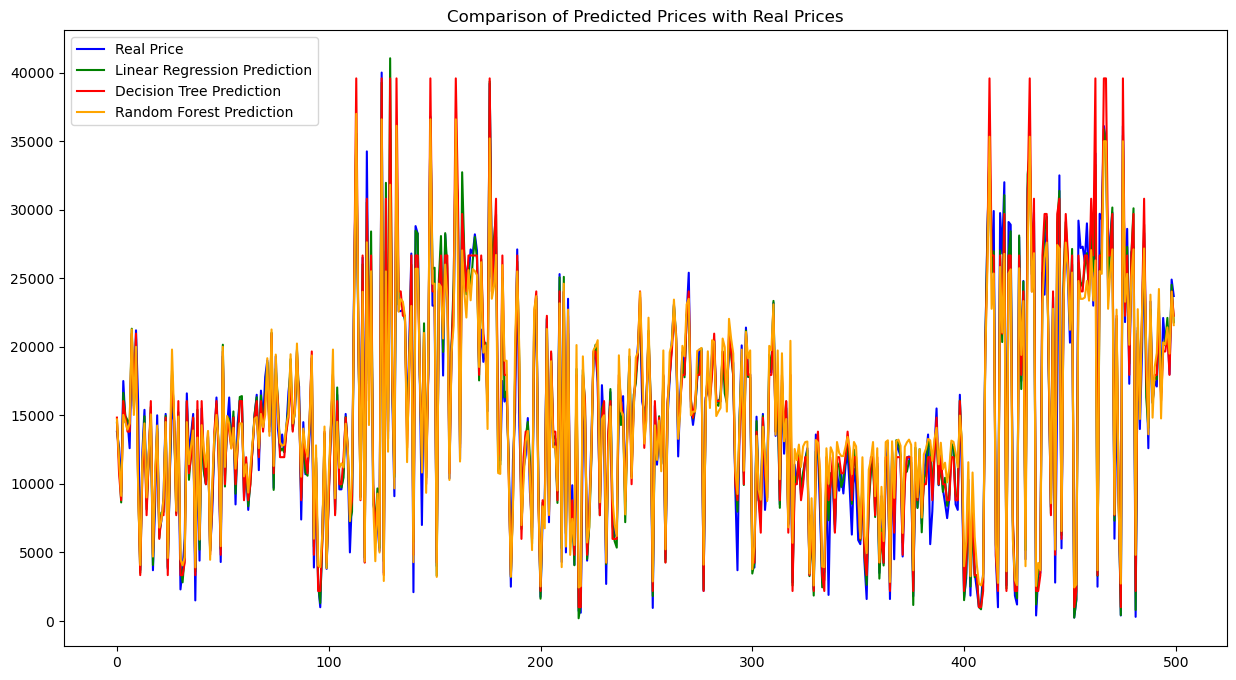

In [138]:
# 创建折线图
plt.figure(figsize=(15, 8))

# 绘制真实汽车价格
plt.plot(real_price[:500], label="Real Price", color="blue")

# 绘制第一种方法的预测价格
plt.plot(lr_price[:500], label="Linear Regression Prediction", color="green")

# 绘制第二种方法的预测价格
plt.plot(dt_price[:500], label="Decision Tree Prediction", color="red")

# 绘制第三种方法的预测价格
plt.plot(rf_price[:500], label="Random Forest Prediction", color="orange")

# 添加标题和图例
plt.title("Comparison of Predicted Prices with Real Prices")
plt.legend()

# 显示图形
plt.show()

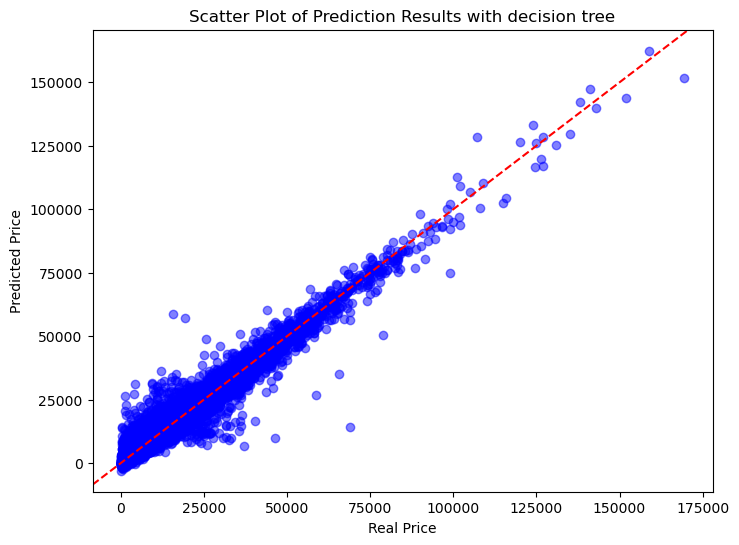

In [139]:
draw_comparison_scatter_figure(lr_price, title="Scatter Plot of Prediction Results with decision tree")

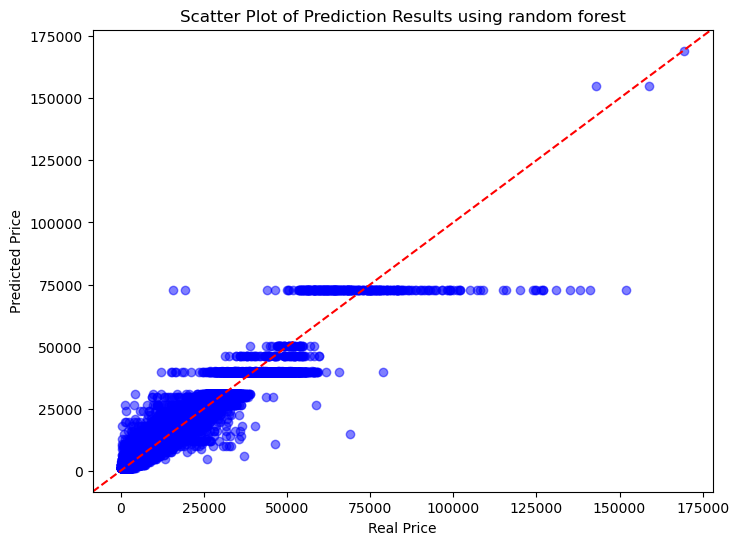

In [140]:
draw_comparison_scatter_figure(dt_price, title="Scatter Plot of Prediction Results using random forest")

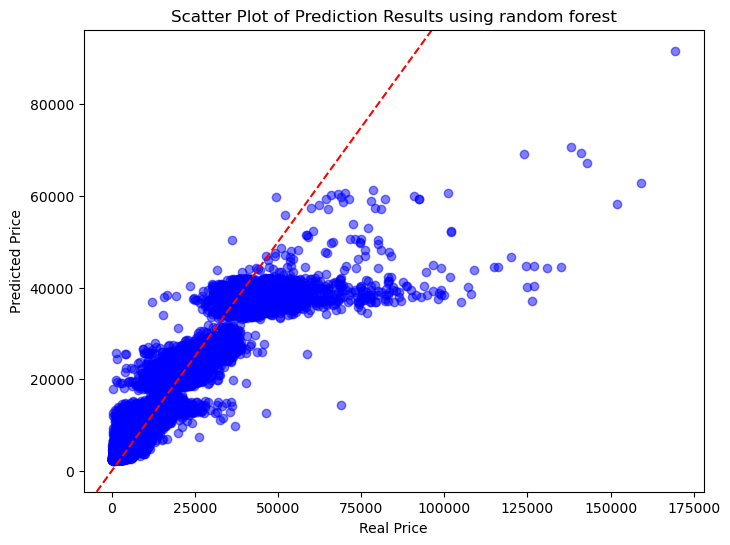

In [141]:
draw_comparison_scatter_figure(rf_price, title="Scatter Plot of Prediction Results using random forest")

In [142]:
# 创建一个列表，包含表头和数据
table = [
    ["Method", "R^2", "RMSE", "MAE"],
    ["Linear Regression", lr_r2, lr_rmse, lr_mae],
    ["Decision Tree", dt_r2, dt_rmse, dt_mae],
    ["Random Forest", rf_r2, rf_rmse, rf_mae]
]

# 使用 tabulate 函数生成表格
table_str = tabulate(table, headers="firstrow", tablefmt="fancy_grid")

# 打印表格
print(table_str)

╒═══════════════════╤══════════╤═════════╤═════════╕
│ Method            │      R^2 │    RMSE │     MAE │
╞═══════════════════╪══════════╪═════════╪═════════╡
│ Linear Regression │ 0.971121 │ 1621.35 │ 1027.33 │
├───────────────────┼──────────┼─────────┼─────────┤
│ Decision Tree     │ 0.946604 │ 2204.65 │ 1268.98 │
├───────────────────┼──────────┼─────────┼─────────┤
│ Random Forest     │ 0.891349 │ 3144.87 │ 1731.64 │
╘═══════════════════╧══════════╧═════════╧═════════╛


### Performance Test

In [143]:
train.rdd.getNumPartitions()

19

In [144]:
one_par_train = train.repartition(1)
one_par_train.rdd.getNumPartitions()

24/04/29 01:55:24 WARN DAGScheduler: Broadcasting large task binary with size 1111.3 KiB


1

In [145]:
lr_single = LinearRegression(featuresCol='features', labelCol='sellingprice')
dt_single = DecisionTreeRegressor(featuresCol='features', labelCol='sellingprice')
rf_single = RandomForestRegressor(featuresCol='features', labelCol='sellingprice')

In [146]:
@timer
def lr_single_training():
    lr_single.fit(one_par_train)

lr_single_training()

24/04/29 01:55:25 WARN DAGScheduler: Broadcasting large task binary with size 1111.3 KiB


24/04/29 01:55:27 WARN DAGScheduler: Broadcasting large task binary with size 1111.3 KiB


24/04/29 01:55:28 WARN Instrumentation: [6e048b02] regParam is zero, which might cause numerical instability and overfitting.


24/04/29 01:55:28 WARN Instrumentation: [6e048b02] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
24/04/29 01:55:28 WARN DAGScheduler: Broadcasting large task binary with size 1111.3 KiB


It took 3.7366957664489746 second(s)


In [147]:
@timer
def dt_single_training():
    dt_single.fit(one_par_train)
    
dt_single_training()

24/04/29 01:55:29 WARN DAGScheduler: Broadcasting large task binary with size 1111.3 KiB


24/04/29 01:55:31 WARN MemoryStore: Not enough space to cache rdd_1384_0 in memory! (computed 348.3 MiB so far)
24/04/29 01:55:31 WARN BlockManager: Persisting block rdd_1384_0 to disk instead.
24/04/29 01:55:35 WARN MemoryStore: Not enough space to cache rdd_1384_0 in memory! (computed 349.6 MiB so far)


24/04/29 01:55:37 WARN MemoryStore: Not enough space to cache rdd_1384_0 in memory! (computed 349.6 MiB so far)


24/04/29 01:55:39 WARN MemoryStore: Not enough space to cache rdd_1384_0 in memory! (computed 349.6 MiB so far)


24/04/29 01:55:41 WARN MemoryStore: Not enough space to cache rdd_1384_0 in memory! (computed 349.6 MiB so far)


24/04/29 01:55:42 WARN MemoryStore: Not enough space to cache rdd_1384_0 in memory! (computed 349.6 MiB so far)


It took 14.856062412261963 second(s)


In [148]:
@timer
def rf_single_training():
    rf_single.fit(one_par_train)

rf_single_training()

24/04/29 01:55:44 WARN DAGScheduler: Broadcasting large task binary with size 1111.3 KiB


24/04/29 01:55:46 WARN MemoryStore: Not enough space to cache rdd_1418_0 in memory! (computed 356.6 MiB so far)
24/04/29 01:55:46 WARN BlockManager: Persisting block rdd_1418_0 to disk instead.
24/04/29 01:55:50 WARN MemoryStore: Not enough space to cache rdd_1418_0 in memory! (computed 356.6 MiB so far)


24/04/29 01:55:55 WARN DAGScheduler: Broadcasting large task binary with size 1031.9 KiB
24/04/29 01:55:56 WARN MemoryStore: Not enough space to cache rdd_1418_0 in memory! (computed 356.6 MiB so far)


24/04/29 01:56:02 WARN DAGScheduler: Broadcasting large task binary with size 1094.8 KiB
24/04/29 01:56:02 WARN MemoryStore: Not enough space to cache rdd_1418_0 in memory! (computed 356.6 MiB so far)


24/04/29 01:56:09 WARN DAGScheduler: Broadcasting large task binary with size 1221.1 KiB
24/04/29 01:56:09 WARN MemoryStore: Not enough space to cache rdd_1418_0 in memory! (computed 356.6 MiB so far)


24/04/29 01:56:16 WARN DAGScheduler: Broadcasting large task binary with size 1469.6 KiB


24/04/29 01:56:17 WARN MemoryStore: Not enough space to cache rdd_1418_0 in memory! (computed 356.6 MiB so far)
It took 40.35605978965759 second(s)


In [149]:
ten_par_train = train.repartition(10)
ten_par_train.rdd.getNumPartitions()

24/04/29 01:56:24 WARN DAGScheduler: Broadcasting large task binary with size 1111.6 KiB


10

In [150]:
lr_ten = LinearRegression(featuresCol='features', labelCol='sellingprice')
dt_ten = DecisionTreeRegressor(featuresCol='features', labelCol='sellingprice')
rf_ten = RandomForestRegressor(featuresCol='features', labelCol='sellingprice')

In [151]:
@timer
def lr_ten_training():
    lr_ten.fit(ten_par_train)

lr_ten_training()

24/04/29 01:56:26 WARN DAGScheduler: Broadcasting large task binary with size 1111.6 KiB


24/04/29 01:56:26 WARN DAGScheduler: Broadcasting large task binary with size 1111.6 KiB


24/04/29 01:56:27 WARN Instrumentation: [d779ab2f] regParam is zero, which might cause numerical instability and overfitting.
24/04/29 01:56:27 WARN Instrumentation: [d779ab2f] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


24/04/29 01:56:28 WARN DAGScheduler: Broadcasting large task binary with size 1111.6 KiB


It took 3.1673085689544678 second(s)


In [152]:
@timer
def dt_ten_training():
    dt_ten.fit(ten_par_train)
    
dt_ten_training()

24/04/29 01:56:29 WARN DAGScheduler: Broadcasting large task binary with size 1111.6 KiB


24/04/29 01:56:30 WARN MemoryStore: Not enough space to cache rdd_1502_3 in memory! (computed 44.2 MiB so far)
24/04/29 01:56:30 WARN MemoryStore: Not enough space to cache rdd_1502_8 in memory! (computed 44.2 MiB so far)
24/04/29 01:56:30 WARN MemoryStore: Not enough space to cache rdd_1502_5 in memory! (computed 29.2 MiB so far)
24/04/29 01:56:30 WARN MemoryStore: Not enough space to cache rdd_1502_9 in memory! (computed 29.2 MiB so far)
24/04/29 01:56:30 WARN MemoryStore: Not enough space to cache rdd_1502_7 in memory! (computed 29.2 MiB so far)
24/04/29 01:56:30 WARN BlockManager: Persisting block rdd_1502_5 to disk instead.
24/04/29 01:56:30 WARN MemoryStore: Not enough space to cache rdd_1502_4 in memory! (computed 29.2 MiB so far)
24/04/29 01:56:30 WARN MemoryStore: Not enough space to cache rdd_1502_0 in memory! (computed 29.2 MiB so far)
24/04/29 01:56:30 WARN BlockManager: Persisting block rdd_1502_7 to disk instead.
24/04/29 01:56:30 WARN BlockManager: Persisting block rdd_1

24/04/29 01:56:31 WARN MemoryStore: Not enough space to cache rdd_1502_0 in memory! (computed 19.4 MiB so far)
24/04/29 01:56:31 WARN MemoryStore: Not enough space to cache rdd_1502_4 in memory! (computed 19.4 MiB so far)
24/04/29 01:56:31 WARN MemoryStore: Not enough space to cache rdd_1502_8 in memory! (computed 43.9 MiB so far)
24/04/29 01:56:31 WARN MemoryStore: Not enough space to cache rdd_1502_2 in memory! (computed 29.2 MiB so far)
24/04/29 01:56:31 WARN MemoryStore: Not enough space to cache rdd_1502_7 in memory! (computed 1639.1 KiB so far)
24/04/29 01:56:31 WARN MemoryStore: Not enough space to cache rdd_1502_6 in memory! (computed 29.2 MiB so far)
24/04/29 01:56:31 WARN MemoryStore: Not enough space to cache rdd_1502_3 in memory! (computed 68.9 MiB so far)
24/04/29 01:56:31 WARN MemoryStore: Not enough space to cache rdd_1502_9 in memory! (computed 103.5 MiB so far)
24/04/29 01:56:31 WARN MemoryStore: Not enough space to cache rdd_1502_5 in memory! (computed 103.5 MiB so fa

24/04/29 01:56:31 WARN MemoryStore: Not enough space to cache rdd_1502_3 in memory! (computed 19.4 MiB so far)
24/04/29 01:56:31 WARN MemoryStore: Not enough space to cache rdd_1502_8 in memory! (computed 19.4 MiB so far)
24/04/29 01:56:31 WARN MemoryStore: Not enough space to cache rdd_1502_9 in memory! (computed 19.4 MiB so far)
24/04/29 01:56:31 WARN MemoryStore: Not enough space to cache rdd_1502_7 in memory! (computed 29.2 MiB so far)
24/04/29 01:56:31 WARN MemoryStore: Not enough space to cache rdd_1502_2 in memory! (computed 19.4 MiB so far)
24/04/29 01:56:31 WARN MemoryStore: Not enough space to cache rdd_1502_5 in memory! (computed 19.4 MiB so far)
24/04/29 01:56:31 WARN MemoryStore: Not enough space to cache rdd_1502_6 in memory! (computed 29.2 MiB so far)
24/04/29 01:56:31 WARN MemoryStore: Not enough space to cache rdd_1502_4 in memory! (computed 29.2 MiB so far)


24/04/29 01:56:32 WARN MemoryStore: Not enough space to cache rdd_1502_5 in memory! (computed 8.4 MiB so far)
24/04/29 01:56:32 WARN MemoryStore: Not enough space to cache rdd_1502_7 in memory! (computed 5.5 MiB so far)
24/04/29 01:56:32 WARN MemoryStore: Not enough space to cache rdd_1502_9 in memory! (computed 8.4 MiB so far)
24/04/29 01:56:32 WARN MemoryStore: Not enough space to cache rdd_1502_8 in memory! (computed 5.5 MiB so far)
24/04/29 01:56:32 WARN MemoryStore: Not enough space to cache rdd_1502_4 in memory! (computed 12.9 MiB so far)
24/04/29 01:56:32 WARN MemoryStore: Not enough space to cache rdd_1502_6 in memory! (computed 12.9 MiB so far)
24/04/29 01:56:32 WARN MemoryStore: Not enough space to cache rdd_1502_3 in memory! (computed 29.2 MiB so far)
24/04/29 01:56:32 WARN MemoryStore: Not enough space to cache rdd_1502_2 in memory! (computed 68.9 MiB so far)
24/04/29 01:56:32 WARN MemoryStore: Not enough space to cache rdd_1502_7 in memory! (computed 8.4 MiB so far)
24/04/

In [153]:
@timer
def rf_ten_training():
    rf_ten.fit(ten_par_train)

rf_ten_training()

24/04/29 01:56:33 WARN DAGScheduler: Broadcasting large task binary with size 1111.6 KiB


24/04/29 01:56:35 WARN MemoryStore: Not enough space to cache rdd_1537_8 in memory! (computed 29.9 MiB so far)
24/04/29 01:56:35 WARN BlockManager: Persisting block rdd_1537_8 to disk instead.
24/04/29 01:56:35 WARN MemoryStore: Not enough space to cache rdd_1537_3 in memory! (computed 29.9 MiB so far)
24/04/29 01:56:35 WARN BlockManager: Persisting block rdd_1537_3 to disk instead.
24/04/29 01:56:35 WARN MemoryStore: Not enough space to cache rdd_1537_4 in memory! (computed 29.9 MiB so far)
24/04/29 01:56:35 WARN BlockManager: Persisting block rdd_1537_4 to disk instead.
24/04/29 01:56:35 WARN MemoryStore: Not enough space to cache rdd_1537_1 in memory! (computed 29.9 MiB so far)
24/04/29 01:56:35 WARN BlockManager: Persisting block rdd_1537_1 to disk instead.
24/04/29 01:56:35 WARN MemoryStore: Not enough space to cache rdd_1537_6 in memory! (computed 29.9 MiB so far)
24/04/29 01:56:35 WARN BlockManager: Persisting block rdd_1537_6 to disk instead.
24/04/29 01:56:35 WARN MemoryStore:

24/04/29 01:56:35 WARN MemoryStore: Not enough space to cache rdd_1537_2 in memory! (computed 105.6 MiB so far)
24/04/29 01:56:35 WARN BlockManager: Persisting block rdd_1537_2 to disk instead.
24/04/29 01:56:35 WARN MemoryStore: Not enough space to cache rdd_1537_7 in memory! (computed 105.6 MiB so far)
24/04/29 01:56:35 WARN BlockManager: Persisting block rdd_1537_7 to disk instead.
24/04/29 01:56:35 WARN MemoryStore: Not enough space to cache rdd_1537_5 in memory! (computed 105.6 MiB so far)
24/04/29 01:56:35 WARN BlockManager: Persisting block rdd_1537_5 to disk instead.
24/04/29 01:56:36 WARN MemoryStore: Not enough space to cache rdd_1537_4 in memory! (computed 45.3 MiB so far)
24/04/29 01:56:36 WARN MemoryStore: Not enough space to cache rdd_1537_6 in memory! (computed 29.9 MiB so far)
24/04/29 01:56:36 WARN MemoryStore: Not enough space to cache rdd_1537_2 in memory! (computed 45.3 MiB so far)
24/04/29 01:56:36 WARN MemoryStore: Not enough space to cache rdd_1537_8 in memory! (

24/04/29 01:56:37 WARN DAGScheduler: Broadcasting large task binary with size 1032.2 KiB
24/04/29 01:56:37 WARN MemoryStore: Not enough space to cache rdd_1537_3 in memory! (computed 29.9 MiB so far)
24/04/29 01:56:37 WARN MemoryStore: Not enough space to cache rdd_1537_0 in memory! (computed 29.9 MiB so far)
24/04/29 01:56:37 WARN MemoryStore: Not enough space to cache rdd_1537_9 in memory! (computed 29.9 MiB so far)
24/04/29 01:56:37 WARN MemoryStore: Not enough space to cache rdd_1537_5 in memory! (computed 29.9 MiB so far)
24/04/29 01:56:37 WARN MemoryStore: Not enough space to cache rdd_1537_4 in memory! (computed 29.9 MiB so far)
24/04/29 01:56:37 WARN MemoryStore: Not enough space to cache rdd_1537_7 in memory! (computed 29.9 MiB so far)
24/04/29 01:56:37 WARN MemoryStore: Not enough space to cache rdd_1537_2 in memory! (computed 45.3 MiB so far)
24/04/29 01:56:37 WARN MemoryStore: Not enough space to cache rdd_1537_1 in memory! (computed 45.3 MiB so far)
24/04/29 01:56:37 WARN 

24/04/29 01:56:38 WARN DAGScheduler: Broadcasting large task binary with size 1095.3 KiB
24/04/29 01:56:39 WARN MemoryStore: Not enough space to cache rdd_1537_4 in memory! (computed 29.9 MiB so far)
24/04/29 01:56:39 WARN MemoryStore: Not enough space to cache rdd_1537_7 in memory! (computed 29.9 MiB so far)
24/04/29 01:56:39 WARN MemoryStore: Not enough space to cache rdd_1537_0 in memory! (computed 29.9 MiB so far)
24/04/29 01:56:39 WARN MemoryStore: Not enough space to cache rdd_1537_2 in memory! (computed 29.9 MiB so far)
24/04/29 01:56:39 WARN MemoryStore: Not enough space to cache rdd_1537_9 in memory! (computed 29.9 MiB so far)
24/04/29 01:56:39 WARN MemoryStore: Not enough space to cache rdd_1537_5 in memory! (computed 29.9 MiB so far)
24/04/29 01:56:39 WARN MemoryStore: Not enough space to cache rdd_1537_8 in memory! (computed 45.3 MiB so far)
24/04/29 01:56:39 WARN MemoryStore: Not enough space to cache rdd_1537_1 in memory! (computed 45.3 MiB so far)
24/04/29 01:56:39 WARN 

24/04/29 01:56:40 WARN DAGScheduler: Broadcasting large task binary with size 1221.7 KiB
24/04/29 01:56:40 WARN MemoryStore: Not enough space to cache rdd_1537_0 in memory! (computed 29.9 MiB so far)
24/04/29 01:56:40 WARN MemoryStore: Not enough space to cache rdd_1537_8 in memory! (computed 29.9 MiB so far)
24/04/29 01:56:40 WARN MemoryStore: Not enough space to cache rdd_1537_3 in memory! (computed 29.9 MiB so far)
24/04/29 01:56:40 WARN MemoryStore: Not enough space to cache rdd_1537_2 in memory! (computed 29.9 MiB so far)
24/04/29 01:56:40 WARN MemoryStore: Not enough space to cache rdd_1537_6 in memory! (computed 29.9 MiB so far)
24/04/29 01:56:40 WARN MemoryStore: Not enough space to cache rdd_1537_5 in memory! (computed 29.9 MiB so far)
24/04/29 01:56:40 WARN MemoryStore: Not enough space to cache rdd_1537_4 in memory! (computed 45.3 MiB so far)
24/04/29 01:56:40 WARN MemoryStore: Not enough space to cache rdd_1537_9 in memory! (computed 45.3 MiB so far)
24/04/29 01:56:40 WARN 

24/04/29 01:56:43 WARN DAGScheduler: Broadcasting large task binary with size 1470.8 KiB
24/04/29 01:56:43 WARN MemoryStore: Not enough space to cache rdd_1537_7 in memory! (computed 29.9 MiB so far)
24/04/29 01:56:43 WARN MemoryStore: Not enough space to cache rdd_1537_2 in memory! (computed 29.9 MiB so far)
24/04/29 01:56:43 WARN MemoryStore: Not enough space to cache rdd_1537_5 in memory! (computed 29.9 MiB so far)
24/04/29 01:56:43 WARN MemoryStore: Not enough space to cache rdd_1537_3 in memory! (computed 29.9 MiB so far)
24/04/29 01:56:43 WARN MemoryStore: Not enough space to cache rdd_1537_9 in memory! (computed 29.9 MiB so far)
24/04/29 01:56:43 WARN MemoryStore: Not enough space to cache rdd_1537_1 in memory! (computed 29.9 MiB so far)
24/04/29 01:56:43 WARN MemoryStore: Not enough space to cache rdd_1537_0 in memory! (computed 45.3 MiB so far)
24/04/29 01:56:43 WARN MemoryStore: Not enough space to cache rdd_1537_8 in memory! (computed 45.3 MiB so far)
24/04/29 01:56:43 WARN 

It took 14.677613019943237 second(s)


In [154]:
times

[2.90539288520813,
 6.7500128746032715,
 16.582366943359375,
 3.7366957664489746,
 14.856062412261963,
 40.35605978965759,
 3.1673085689544678,
 4.434158086776733,
 14.677613019943237]

In [155]:
parallel_num = train.rdd.getNumPartitions()
single_num = one_par_train.rdd.getNumPartitions()
ten_pars_num = ten_par_train.rdd.getNumPartitions()

print(
    tabulate(
        [
            ["Method", "Partitions", "Time"],
            ["Linear Regression", single_num, times[3]],
            ["Linear Regression", ten_pars_num, times[6]],
            ["Linear Regression", parallel_num, times[0]],
            ["Decision Tree", single_num, times[4]],
            ["Decision Tree", ten_pars_num, times[7]],
            ["Decision Tree", parallel_num, times[1]],
            ["Random Forest", single_num, times[5]],
            ["Random Forest", ten_pars_num, times[8]],
            ["Random Forest", parallel_num, times[2]],
        ],
        headers="firstrow",
        tablefmt="fancy_grid"
    )
)

╒═══════════════════╤══════════════╤══════════╕
│ Method            │   Partitions │     Time │
╞═══════════════════╪══════════════╪══════════╡
│ Linear Regression │            1 │  3.7367  │
├───────────────────┼──────────────┼──────────┤
│ Linear Regression │           10 │  3.16731 │
├───────────────────┼──────────────┼──────────┤
│ Linear Regression │           19 │  2.90539 │
├───────────────────┼──────────────┼──────────┤
│ Decision Tree     │            1 │ 14.8561  │
├───────────────────┼──────────────┼──────────┤
│ Decision Tree     │           10 │  4.43416 │
├───────────────────┼──────────────┼──────────┤
│ Decision Tree     │           19 │  6.75001 │
├───────────────────┼──────────────┼──────────┤
│ Random Forest     │            1 │ 40.3561  │
├───────────────────┼──────────────┼──────────┤
│ Random Forest     │           10 │ 14.6776  │
├───────────────────┼──────────────┼──────────┤
│ Random Forest     │           19 │ 16.5824  │
╘═══════════════════╧══════════════╧════